# Session 10: Time-Varying Parameter VAR (Part 1)
# Foundations and State Space Models

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand why constant-parameter models may be inadequate
2. Specify state space models for time-varying parameters
3. Implement the Kalman filter for parameter estimation
4. Estimate simple TVP models with known variance
5. Detect structural breaks and parameter instability
6. Apply rolling window estimation
7. Understand the bias-variance tradeoff in TVP models
8. Prepare for TVP-VAR estimation (Session 11)

### Prerequisites
- Session 8: Vector Autoregression (VAR)
- Session 9: Cointegration and VECM
- Understanding of state space models
- Knowledge of Kalman filtering (helpful but not required)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.linalg import block_diag
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.regression.rolling import RollingOLS
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Motivation: Why Time-Varying Parameters?

### 1.1 Limitations of Constant-Parameter Models

**Standard VAR assumption**: Parameters are constant over time.

$$\mathbf{y}_t = \mathbf{c} + \Phi_1 \mathbf{y}_{t-1} + \cdots + \Phi_p \mathbf{y}_{t-p} + \mathbf{\epsilon}_t$$

**Problems**:
1. **Structural breaks**: Policy regime changes, crises, technology shifts
2. **Evolving relationships**: Globalization, market integration
3. **Time-varying volatility**: GARCH effects at macro level
4. **Sample selection**: Using only recent data wastes information

### 1.2 Evidence of Parameter Instability

**Empirical findings**:
- **Great Moderation** (1980s-2007): Reduced volatility in macro variables
- **Financial crisis** (2008): Changed correlations between assets
- **Monetary policy**: Fed behavior different across eras
- **COVID-19**: Unprecedented shifts in economic relationships

**Tests for stability**:
- Chow test for known break date
- CUSUM test for unknown break
- Quandt-Andrews test for multiple breaks
- Recursive estimation plots

### 1.3 Approaches to Time-Variation

**1. Rolling Windows**
- Simple: Estimate over moving window
- Pro: Easy to implement
- Con: Arbitrary window size, inefficient

**2. Structural Break Models**
- Identify discrete breaks
- Pro: Interpretable
- Con: May miss gradual changes

**3. Time-Varying Parameter (TVP) Models**
- Parameters evolve smoothly over time
- Pro: Flexible, uses all data
- Con: More complex estimation

**4. Regime-Switching Models**
- Discrete states (e.g., recession/expansion)
- Pro: Matches narrative
- Con: Pre-specified number of states

In [6]:
# Download data to demonstrate parameter instability
print("\n" + "="*60)
print("Downloading Economic/Financial Data")
print("="*60)

# Get S&P 500 and VIX for long period to show regime changes
tickers = ['^GSPC', '^VIX']
data = yf.download(tickers, start='2000-01-01', end='2024-01-01', progress=False)['Close']
data.columns = ['SP500', 'VIX']
data = data.dropna()

# Calculate returns
returns = data['SP500'].pct_change().dropna() * 100
vix_change = data['VIX'].diff().dropna()

# Combine
df = pd.DataFrame({
    'SP500_Return': returns,
    'VIX_Change': vix_change
}).dropna()

print(f"\nData period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Observations: {len(df)}")
print(f"\nThis period includes:")
print("  • Dot-com bubble burst (2000-2002)")
print("  • Financial crisis (2008-2009)")
print("  • COVID-19 pandemic (2020)")
print("  • Various Fed policy regimes")

print("\nDescriptive Statistics:")
print(df.describe().round(4))



Data period: 2000-01-04 to 2023-12-29
Observations: 6036

This period includes:
  • Dot-com bubble burst (2000-2002)
  • Financial crisis (2008-2009)
  • COVID-19 pandemic (2020)
  • Various Fed policy regimes

Descriptive Statistics:
       SP500_Return  VIX_Change
count     6036.0000   6036.0000
mean         0.0273     -0.0019
std          1.2360      1.7921
min        -11.9841    -17.6400
25%         -0.4873     -0.7300
50%          0.0588     -0.0900
75%          0.5937      0.5900
max         11.5800     24.8600


In [8]:
# Test for structural breaks using rolling estimation
print("\n" + "="*60)
print("Evidence of Parameter Instability")
print("="*60)

# Simple regression: SP500_Return on VIX_Change
from sklearn.linear_model import LinearRegression

# Full sample estimate
X_full = df['VIX_Change'].values.reshape(-1, 1)
y_full = df['SP500_Return'].values

reg_full = LinearRegression()
reg_full.fit(X_full, y_full)

print("\nFull Sample Regression:")
print(f"  SP500_Return = {reg_full.intercept_:.4f} + {reg_full.coef_[0]:.4f} * VIX_Change")
print(f"  R²: {reg_full.score(X_full, y_full):.4f}")

# Rolling window estimation
window = 252  # 1 year
rolling_coef = []
rolling_intercept = []
rolling_dates = []

for i in range(window, len(df)):
    X_window = df['VIX_Change'].iloc[i-window:i].values.reshape(-1, 1)
    y_window = df['SP500_Return'].iloc[i-window:i].values
    
    reg_window = LinearRegression()
    reg_window.fit(X_window, y_window)
    
    rolling_coef.append(reg_window.coef_[0])
    rolling_intercept.append(reg_window.intercept_)
    rolling_dates.append(df.index[i])

rolling_results = pd.DataFrame({
    'beta': rolling_coef,
    'alpha': rolling_intercept
}, index=rolling_dates)

print(f"\nRolling Window ({window}-day) Statistics:")
print(f"  Beta (VIX_Change coefficient):")
print(f"    Mean: {rolling_results['beta'].mean():.4f}")
print(f"    Std:  {rolling_results['beta'].std():.4f}")
print(f"    Min:  {rolling_results['beta'].min():.4f}")
print(f"    Max:  {rolling_results['beta'].max():.4f}")
print(f"\n  → Coefficient varies substantially over time!")


Evidence of Parameter Instability

Full Sample Regression:
  SP500_Return = 0.0262 + -0.5534 * VIX_Change
  R²: 0.6438

Rolling Window (252-day) Statistics:
  Beta (VIX_Change coefficient):
    Mean: -0.5734
    Std:  0.1296
    Min:  -0.8551
    Max:  -0.2574

  → Coefficient varies substantially over time!


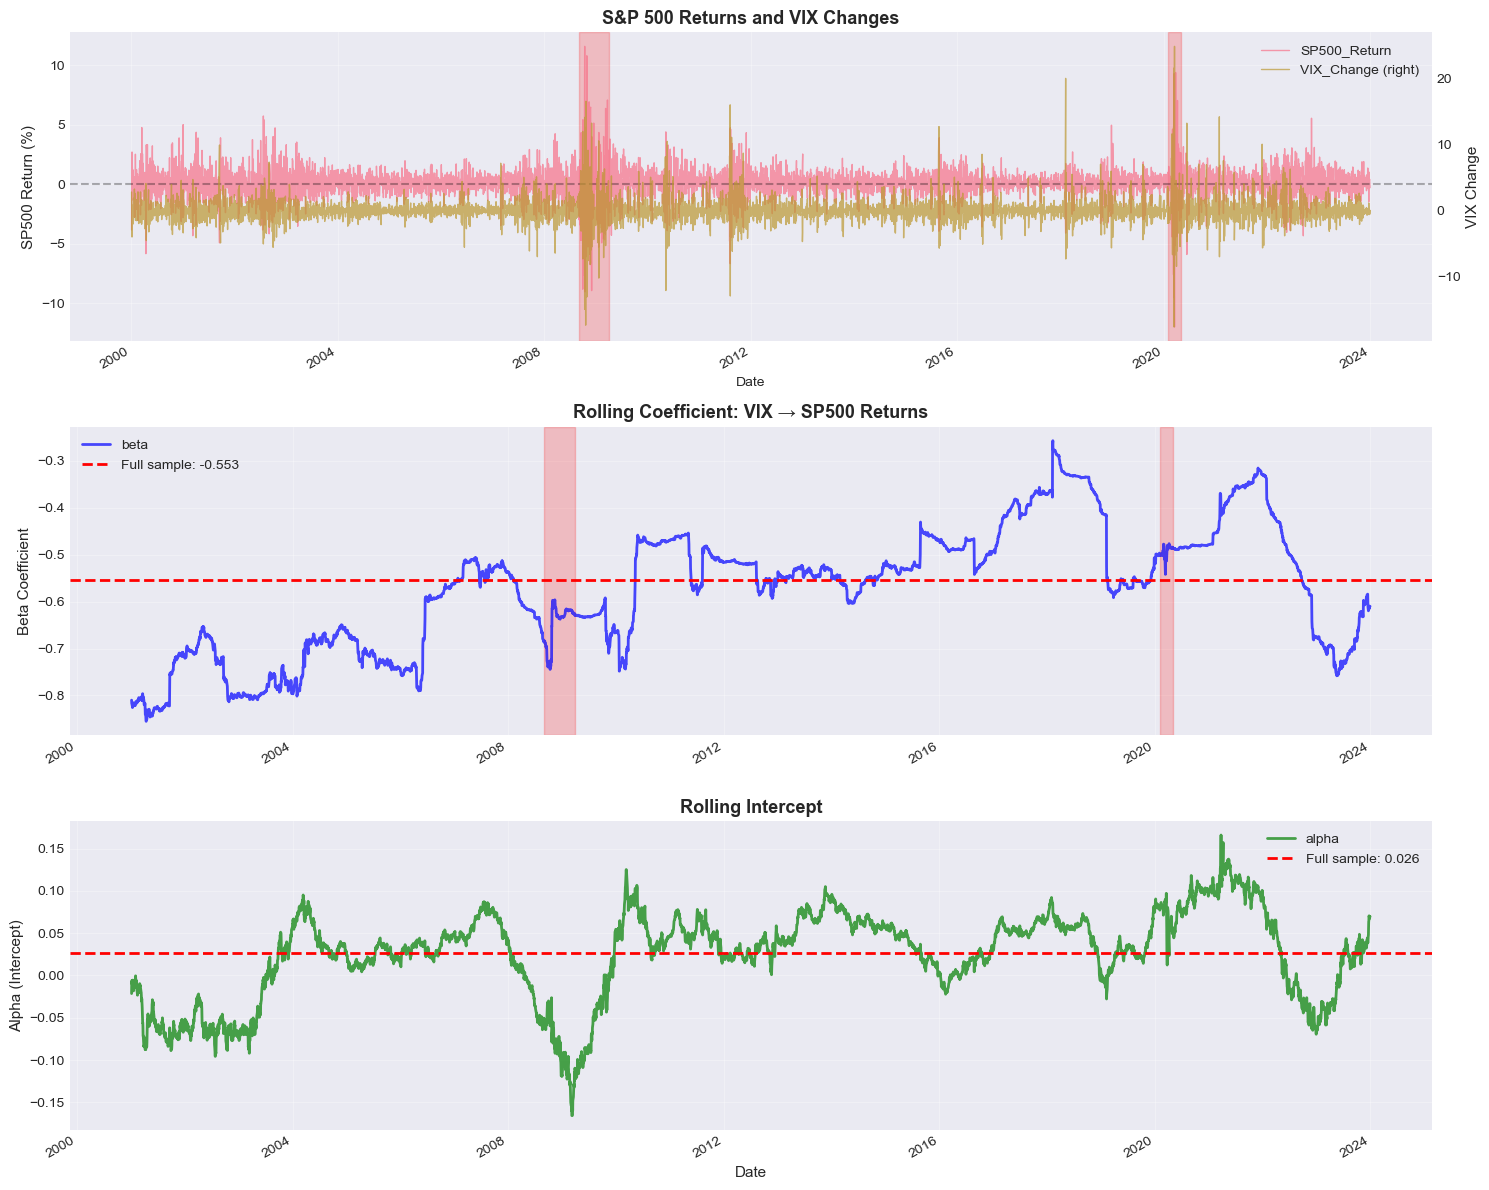


Key Observations:
• Relationship between VIX and S&P 500 changes over time
• Especially unstable during crisis periods
• Full-sample estimate masks important variation
• Constant-parameter model may be inadequate


In [9]:
# Visualize parameter instability
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Data
df[['SP500_Return', 'VIX_Change']].plot(ax=axes[0], linewidth=1, alpha=0.7,
                                        secondary_y='VIX_Change')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0].set_title('S&P 500 Returns and VIX Changes', fontsize=13, fontweight='bold')
axes[0].set_ylabel('SP500 Return (%)', fontsize=11)
axes[0].right_ax.set_ylabel('VIX Change', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add crisis periods
crisis_periods = [
    ('2008-09-01', '2009-03-31', 'Financial Crisis'),
    ('2020-02-01', '2020-04-30', 'COVID-19')
]
for start, end, label in crisis_periods:
    axes[0].axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                    alpha=0.2, color='red')

# Rolling coefficient
rolling_results['beta'].plot(ax=axes[1], linewidth=2, color='blue', alpha=0.7)
axes[1].axhline(y=reg_full.coef_[0], color='red', linestyle='--', linewidth=2,
               label=f'Full sample: {reg_full.coef_[0]:.3f}')
axes[1].set_title('Rolling Coefficient: VIX → SP500 Returns', 
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('Beta Coefficient', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add crisis periods
for start, end, label in crisis_periods:
    axes[1].axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                    alpha=0.2, color='red', label=label if label == crisis_periods[0][2] else '')

# Rolling intercept
rolling_results['alpha'].plot(ax=axes[2], linewidth=2, color='green', alpha=0.7)
axes[2].axhline(y=reg_full.intercept_, color='red', linestyle='--', linewidth=2,
               label=f'Full sample: {reg_full.intercept_:.3f}')
axes[2].set_title('Rolling Intercept', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Alpha (Intercept)', fontsize=11)
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Relationship between VIX and S&P 500 changes over time")
print("• Especially unstable during crisis periods")
print("• Full-sample estimate masks important variation")
print("• Constant-parameter model may be inadequate")

## 2. State Space Models and Kalman Filter

### 2.1 State Space Representation

**Two equations**:

**Observation (Measurement) equation**:
$$\mathbf{y}_t = \mathbf{Z}_t \boldsymbol{\alpha}_t + \mathbf{\epsilon}_t, \quad \mathbf{\epsilon}_t \sim N(\mathbf{0}, \mathbf{H}_t)$$

**State (Transition) equation**:
$$\boldsymbol{\alpha}_t = \mathbf{T}_t \boldsymbol{\alpha}_{t-1} + \mathbf{R}_t \boldsymbol{\eta}_t, \quad \boldsymbol{\eta}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$$

where:
- $\mathbf{y}_t$: Observed variables (data)
- $\boldsymbol{\alpha}_t$: Unobserved state vector (parameters)
- $\mathbf{Z}_t$: Design matrix
- $\mathbf{T}_t$: Transition matrix
- $\mathbf{R}_t$: Selection matrix
- $\mathbf{H}_t$: Observation noise covariance
- $\mathbf{Q}_t$: State noise covariance

### 2.2 TVP Model as State Space

**Simple TVP regression**:
$$y_t = \mathbf{x}_t^\top \boldsymbol{\beta}_t + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)$$
$$\boldsymbol{\beta}_t = \boldsymbol{\beta}_{t-1} + \boldsymbol{\eta}_t, \quad \boldsymbol{\eta}_t \sim N(\mathbf{0}, \mathbf{Q})$$

**Interpretation**:
- $\boldsymbol{\beta}_t$ evolves as **random walk**
- $\mathbf{Q} = \mathbf{0}$: Constant parameters (standard regression)
- $\mathbf{Q} > \mathbf{0}$: Time-varying parameters

### 2.3 Kalman Filter

**Recursive algorithm** to estimate state $\boldsymbol{\alpha}_t$ given observations up to time $t$.

**Prediction step**:
$$\boldsymbol{\alpha}_{t|t-1} = \mathbf{T}_t \boldsymbol{\alpha}_{t-1|t-1}$$
$$\mathbf{P}_{t|t-1} = \mathbf{T}_t \mathbf{P}_{t-1|t-1} \mathbf{T}_t^\top + \mathbf{R}_t \mathbf{Q}_t \mathbf{R}_t^\top$$

**Update step**:
$$\mathbf{v}_t = \mathbf{y}_t - \mathbf{Z}_t \boldsymbol{\alpha}_{t|t-1} \quad \text{(forecast error)}$$
$$\mathbf{F}_t = \mathbf{Z}_t \mathbf{P}_{t|t-1} \mathbf{Z}_t^\top + \mathbf{H}_t \quad \text{(forecast variance)}$$
$$\mathbf{K}_t = \mathbf{P}_{t|t-1} \mathbf{Z}_t^\top \mathbf{F}_t^{-1} \quad \text{(Kalman gain)}$$
$$\boldsymbol{\alpha}_{t|t} = \boldsymbol{\alpha}_{t|t-1} + \mathbf{K}_t \mathbf{v}_t$$
$$\mathbf{P}_{t|t} = \mathbf{P}_{t|t-1} - \mathbf{K}_t \mathbf{Z}_t \mathbf{P}_{t|t-1}$$

### 2.4 Kalman Smoother

**Backward recursion** to get $\boldsymbol{\alpha}_{t|T}$ (uses all data):

$$\boldsymbol{\alpha}_{t|T} = \boldsymbol{\alpha}_{t|t} + \mathbf{P}_{t|t} \mathbf{T}_{t+1}^\top \mathbf{P}_{t+1|t}^{-1} (\boldsymbol{\alpha}_{t+1|T} - \mathbf{T}_{t+1} \boldsymbol{\alpha}_{t|t})$$

**Filtered vs Smoothed**:
- Filtered: Uses data up to $t$
- Smoothed: Uses all data (better for historical analysis)

In [12]:
# Implement simple Kalman filter for TVP model
class SimpleKalmanTVP:
    """
    Simple Kalman filter for TVP regression:
    y_t = X_t' * beta_t + eps_t
    beta_t = beta_{t-1} + eta_t
    """
    def __init__(self, y, X, Q, R, beta0=None, P0=None):
        """
        Parameters:
        - y: observations (T x 1)
        - X: regressors (T x k)
        - Q: state noise covariance (k x k)
        - R: observation noise variance (scalar)
        - beta0: initial state (k x 1)
        - P0: initial state covariance (k x k)
        """
        self.y = y
        self.X = X
        self.T = len(y)
        self.k = X.shape[1]
        
        self.Q = Q
        self.R = R
        
        # Initialize
        if beta0 is None:
            self.beta0 = np.zeros(self.k)
        else:
            self.beta0 = beta0
            
        if P0 is None:
            self.P0 = np.eye(self.k) * 10  # Diffuse prior
        else:
            self.P0 = P0
    
    def filter(self):
        """
        Run Kalman filter.
        Returns filtered states and covariances.
        """
        # Storage
        beta_pred = np.zeros((self.T, self.k))
        beta_filt = np.zeros((self.T, self.k))
        P_pred = np.zeros((self.T, self.k, self.k))
        P_filt = np.zeros((self.T, self.k, self.k))
        forecast_error = np.zeros(self.T)
        forecast_var = np.zeros(self.T)
        loglik = 0
        
        # Initial values
        beta_prev = self.beta0
        P_prev = self.P0
        
        for t in range(self.T):
            # Prediction
            beta_pred[t] = beta_prev
            P_pred[t] = P_prev + self.Q
            
            # Forecast error
            y_pred = self.X[t] @ beta_pred[t]
            v = self.y[t] - y_pred
            forecast_error[t] = v
            
            # Forecast variance
            F = self.X[t] @ P_pred[t] @ self.X[t].T + self.R
            forecast_var[t] = F
            
            # Kalman gain
            K = P_pred[t] @ self.X[t].T / F
            
            # Update
            beta_filt[t] = beta_pred[t] + K * v
            P_filt[t] = P_pred[t] - np.outer(K, K) * F
            
            # Log-likelihood
            loglik += -0.5 * (np.log(2*np.pi) + np.log(F) + v**2/F)
            
            # Update for next iteration
            beta_prev = beta_filt[t]
            P_prev = P_filt[t]
        
        self.beta_filt = beta_filt
        self.P_filt = P_filt
        self.forecast_error = forecast_error
        self.forecast_var = forecast_var
        self.loglik = loglik
        
        return beta_filt, P_filt
    
    def smooth(self):
        """
        Run Kalman smoother (backward pass).
        Requires filter to be run first.
        """
        if not hasattr(self, 'beta_filt'):
            self.filter()
        
        beta_smooth = np.zeros((self.T, self.k))
        P_smooth = np.zeros((self.T, self.k, self.k))
        
        # Initialize at T
        beta_smooth[-1] = self.beta_filt[-1]
        P_smooth[-1] = self.P_filt[-1]
        
        # Backward recursion
        for t in range(self.T-2, -1, -1):
            P_pred_next = self.P_filt[t] + self.Q
            J = self.P_filt[t] @ np.linalg.inv(P_pred_next)
            
            beta_smooth[t] = self.beta_filt[t] + J @ (beta_smooth[t+1] - self.beta_filt[t])
            P_smooth[t] = self.P_filt[t] + J @ (P_smooth[t+1] - P_pred_next) @ J.T
        
        self.beta_smooth = beta_smooth
        self.P_smooth = P_smooth
        
        return beta_smooth, P_smooth

print("\n" + "="*60)
print("Kalman Filter Implementation")
print("="*60)
print("\n✓ Simple Kalman filter class defined")
print("  • Filter: Forward pass (real-time estimates)")
print("  • Smoother: Backward pass (use all data)")


Kalman Filter Implementation

✓ Simple Kalman filter class defined
  • Filter: Forward pass (real-time estimates)
  • Smoother: Backward pass (use all data)


In [14]:
# Apply Kalman filter to estimate time-varying regression
print("\n" + "="*60)
print("TVP Regression: VIX → SP500 Returns")
print("="*60)

# Prepare data
y = df['SP500_Return'].values
X = np.column_stack([np.ones(len(df)), df['VIX_Change'].values])

# Set hyperparameters
# Q: How much parameters can vary
# R: Observation noise variance

# Estimate R from OLS residuals
reg_ols = LinearRegression()
reg_ols.fit(X, y)
resid_ols = y - reg_ols.predict(X)
R_est = np.var(resid_ols)

# Set Q (small values = smooth evolution)
q_alpha = 0.001  # For intercept
q_beta = 0.0001   # For slope
Q = np.diag([q_alpha, q_beta])

print(f"\nHyperparameters:")
print(f"  Observation variance (R): {R_est:.4f}")
print(f"  State variance (Q):")
print(f"    Intercept: {q_alpha:.6f}")
print(f"    Slope:     {q_beta:.6f}")

# Run Kalman filter
kf = SimpleKalmanTVP(y, X, Q, R_est)
beta_filt, P_filt = kf.filter()
beta_smooth, P_smooth = kf.smooth()

print("\n✓ Kalman filter and smoother completed")
print(f"  Log-likelihood: {kf.loglik:.2f}")


TVP Regression: VIX → SP500 Returns

Hyperparameters:
  Observation variance (R): 0.5441
  State variance (Q):
    Intercept: 0.001000
    Slope:     0.000100

✓ Kalman filter and smoother completed
  Log-likelihood: -6516.03


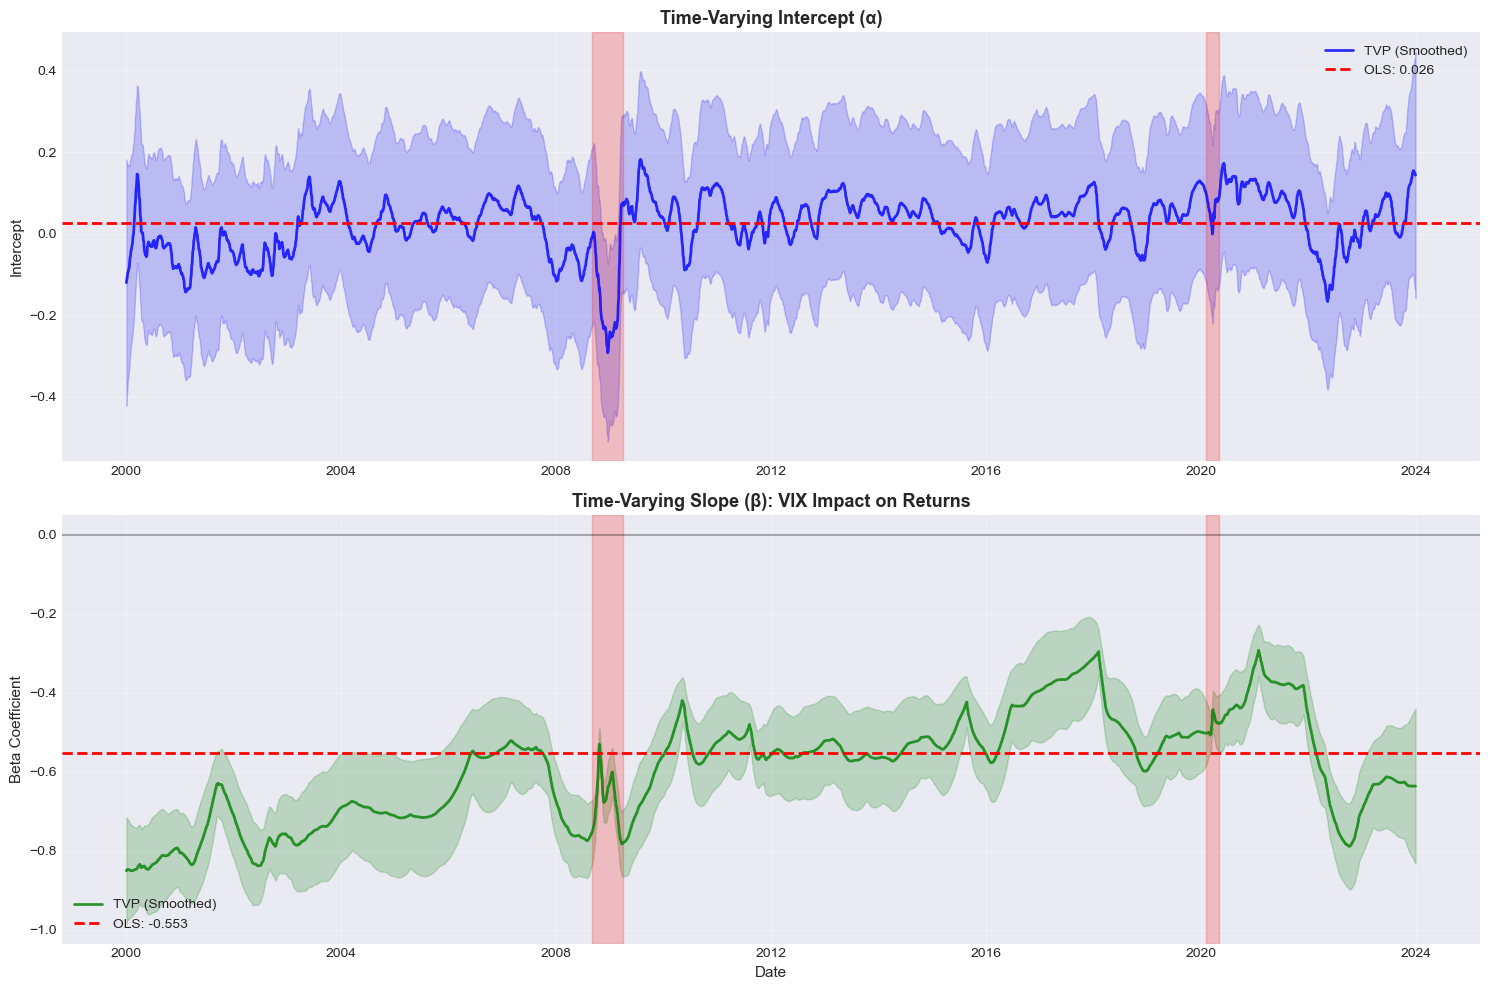


Key Findings:
• Intercept range: [-0.292, 0.182]
• Slope range: [-0.851, -0.293]
• VIX impact becomes more negative during crises
• Parameters evolve smoothly (random walk)
• Confidence bands narrow as more data accumulated


In [16]:
# Visualize time-varying parameters
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Intercept
axes[0].plot(df.index, beta_smooth[:, 0], linewidth=2, color='blue',
            label='TVP (Smoothed)', alpha=0.8)
axes[0].axhline(y=reg_ols.intercept_, color='red', linestyle='--',
               linewidth=2, label=f'OLS: {reg_ols.intercept_:.3f}')

# Confidence bands (±2 SE)
se_alpha = np.sqrt([P_smooth[t, 0, 0] for t in range(len(df))])
axes[0].fill_between(df.index,
                     beta_smooth[:, 0] - 2*se_alpha,
                     beta_smooth[:, 0] + 2*se_alpha,
                     alpha=0.2, color='blue')

axes[0].set_title('Time-Varying Intercept (α)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Intercept', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add crisis periods
for start, end, label in crisis_periods:
    axes[0].axvspan(pd.Timestamp(start), pd.Timestamp(end),
                    alpha=0.2, color='red')

# Slope (VIX coefficient)
axes[1].plot(df.index, beta_smooth[:, 1], linewidth=2, color='green',
            label='TVP (Smoothed)', alpha=0.8)
axes[1].axhline(y=reg_ols.coef_[1], color='red', linestyle='--',
               linewidth=2, label=f'OLS: {reg_ols.coef_[1]:.3f}')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Confidence bands
se_beta = np.sqrt([P_smooth[t, 1, 1] for t in range(len(df))])
axes[1].fill_between(df.index,
                     beta_smooth[:, 1] - 2*se_beta,
                     beta_smooth[:, 1] + 2*se_beta,
                     alpha=0.2, color='green')

axes[1].set_title('Time-Varying Slope (β): VIX Impact on Returns',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Beta Coefficient', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add crisis periods
for start, end, label in crisis_periods:
    axes[1].axvspan(pd.Timestamp(start), pd.Timestamp(end),
                    alpha=0.2, color='red')

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"• Intercept range: [{beta_smooth[:, 0].min():.3f}, {beta_smooth[:, 0].max():.3f}]")
print(f"• Slope range: [{beta_smooth[:, 1].min():.3f}, {beta_smooth[:, 1].max():.3f}]")
print("• VIX impact becomes more negative during crises")
print("• Parameters evolve smoothly (random walk)")
print("• Confidence bands narrow as more data accumulated")

## 3. Comparing Estimation Methods

### 3.1 Full Sample OLS

**Pros**:
- Simple
- Efficient if parameters constant
- Standard inference

**Cons**:
- Ignores time variation
- Averages over regimes
- Poor forecasting if structural change

### 3.2 Rolling Window

**Pros**:
- Simple to implement
- Adapts to recent data
- No distributional assumptions

**Cons**:
- Arbitrary window size
- Wastes old data
- Discrete jumps in estimates
- Inefficient

### 3.3 Kalman Filter (TVP)

**Pros**:
- Uses all data efficiently
- Smooth evolution
- Optimal under assumptions
- Provides uncertainty bands

**Cons**:
- Requires specification of Q, R
- More complex
- Assumes Gaussian errors
- Need good initialization

### 3.4 Bias-Variance Tradeoff

**Small Q** (parameters vary slowly):
- Low variance (smooth estimates)
- High bias if true parameters change fast

**Large Q** (parameters vary rapidly):
- Low bias (tracks changes)
- High variance (noisy estimates)

**Optimal choice**: Balance depends on application


Comparison: OLS vs Rolling vs Kalman


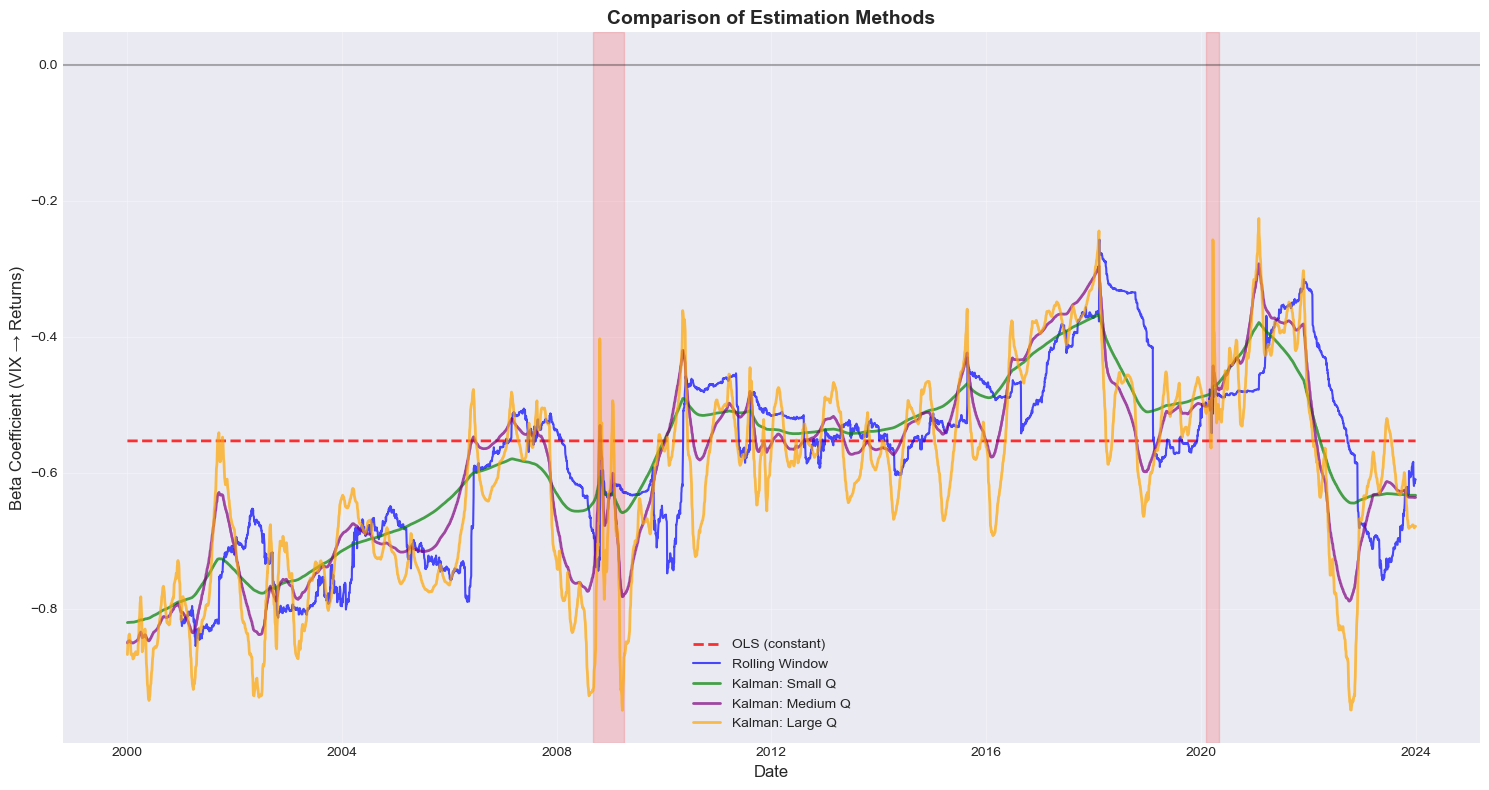


Observations:
• OLS: Constant, misses all time variation
• Rolling: Tracks changes but noisy, discrete jumps
• Kalman (Small Q): Smooth but slow to adapt
• Kalman (Medium Q): Good balance
• Kalman (Large Q): Tracks well but noisy

Choice of Q involves bias-variance tradeoff!


In [18]:
# Compare different estimation methods
print("\n" + "="*60)
print("Comparison: OLS vs Rolling vs Kalman")
print("="*60)

# 1. Full sample OLS (already computed)
beta_ols = np.repeat(reg_ols.coef_[1], len(df))

# 2. Rolling window (already computed)
# Extend to full sample
beta_rolling_full = np.full(len(df), np.nan)
beta_rolling_full[window:] = rolling_results['beta'].values

# 3. Kalman with different Q values
Q_values = {
    'Small Q': np.diag([0.0001, 0.00001]),
    'Medium Q': np.diag([0.001, 0.0001]),
    'Large Q': np.diag([0.01, 0.001])
}

kalman_results = {}
for name, Q_val in Q_values.items():
    kf_temp = SimpleKalmanTVP(y, X, Q_val, R_est)
    beta_temp, _ = kf_temp.smooth()
    kalman_results[name] = beta_temp[:, 1]

# Plot comparison
fig, ax = plt.subplots(figsize=(15, 8))

# Plot all estimates
ax.plot(df.index, beta_ols, linewidth=2, color='red',
       label='OLS (constant)', linestyle='--', alpha=0.8)
ax.plot(df.index, beta_rolling_full, linewidth=1.5, color='blue',
       label='Rolling Window', alpha=0.7)

colors = ['green', 'purple', 'orange']
for (name, beta_est), color in zip(kalman_results.items(), colors):
    ax.plot(df.index, beta_est, linewidth=2, color=color,
           label=f'Kalman: {name}', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_title('Comparison of Estimation Methods', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Beta Coefficient (VIX → Returns)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Add crisis periods
for start, end, label in crisis_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end),
              alpha=0.15, color='red')

plt.tight_layout()
plt.show()

print("\nObservations:")
print("• OLS: Constant, misses all time variation")
print("• Rolling: Tracks changes but noisy, discrete jumps")
print("• Kalman (Small Q): Smooth but slow to adapt")
print("• Kalman (Medium Q): Good balance")
print("• Kalman (Large Q): Tracks well but noisy")
print("\nChoice of Q involves bias-variance tradeoff!")

## 4. Forecasting with TVP Models

### 4.1 One-Step Ahead Forecasts

**Using filtered estimates** (real-time):
$$\hat{y}_{t+1|t} = \mathbf{x}_{t+1}^\top \boldsymbol{\beta}_{t|t}$$

**Using smoothed estimates** (historical analysis):
$$\hat{y}_{t+1|T} = \mathbf{x}_{t+1}^\top \boldsymbol{\beta}_{t|T}$$

### 4.2 Multi-Step Ahead Forecasts

**Parameter forecast**:
$$\boldsymbol{\beta}_{t+h|t} = \boldsymbol{\beta}_{t|t}$$

(Random walk assumption: best forecast is current value)

**Forecast uncertainty**:
$$\text{Var}(\hat{y}_{t+h|t}) = \mathbf{x}_{t+h}^\top \mathbf{P}_{t+h|t} \mathbf{x}_{t+h} + R$$

where $\mathbf{P}_{t+h|t} = \mathbf{P}_{t|t} + h \mathbf{Q}$.

### 4.3 Forecast Evaluation

**Metrics**:
- RMSE: Root mean squared error
- MAE: Mean absolute error
- Log score: Density forecast

**Compare**:
- TVP vs constant parameter
- Different values of Q
- Rolling window vs Kalman filter

In [20]:
# Out-of-sample forecasting comparison
print("\n" + "="*60)
print("Out-of-Sample Forecast Comparison")
print("="*60)

# Split data
train_size = int(len(df) * 0.9)
y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

print(f"\nTraining: {train_size} observations")
print(f"Test: {len(y_test)} observations")

# 1. OLS forecast
reg_train = LinearRegression()
reg_train.fit(X_train, y_train)
forecast_ols = reg_train.predict(X_test)

# 2. TVP forecast (recursive)
forecast_tvp = []
beta_current = beta_smooth[train_size-1]
P_current = P_smooth[train_size-1]

for i in range(len(y_test)):
    # Forecast
    y_pred = X_test[i] @ beta_current
    forecast_tvp.append(y_pred)
    
    # Update with new observation
    # Prediction
    P_pred = P_current + Q
    
    # Update
    v = y_test[i] - y_pred
    F = X_test[i] @ P_pred @ X_test[i].T + R_est
    K = P_pred @ X_test[i].T / F
    
    beta_current = beta_current + K * v
    P_current = P_pred - np.outer(K, K) * F

forecast_tvp = np.array(forecast_tvp)

# Calculate errors
error_ols = y_test - forecast_ols
error_tvp = y_test - forecast_tvp

# Metrics
rmse_ols = np.sqrt(np.mean(error_ols**2))
rmse_tvp = np.sqrt(np.mean(error_tvp**2))
mae_ols = np.mean(np.abs(error_ols))
mae_tvp = np.mean(np.abs(error_tvp))

print("\nForecast Performance:")
print(f"\nOLS:")
print(f"  RMSE: {rmse_ols:.4f}")
print(f"  MAE:  {mae_ols:.4f}")
print(f"\nTVP (Kalman):")
print(f"  RMSE: {rmse_tvp:.4f}")
print(f"  MAE:  {mae_tvp:.4f}")
print(f"\nImprovement:")
print(f"  RMSE: {(1 - rmse_tvp/rmse_ols)*100:.2f}%")
print(f"  MAE:  {(1 - mae_tvp/mae_ols)*100:.2f}%")


Out-of-Sample Forecast Comparison

Training: 5432 observations
Test: 604 observations

Forecast Performance:

OLS:
  RMSE: 0.7666
  MAE:  0.5598

TVP (Kalman):
  RMSE: 0.7477
  MAE:  0.5477

Improvement:
  RMSE: 2.47%
  MAE:  2.15%


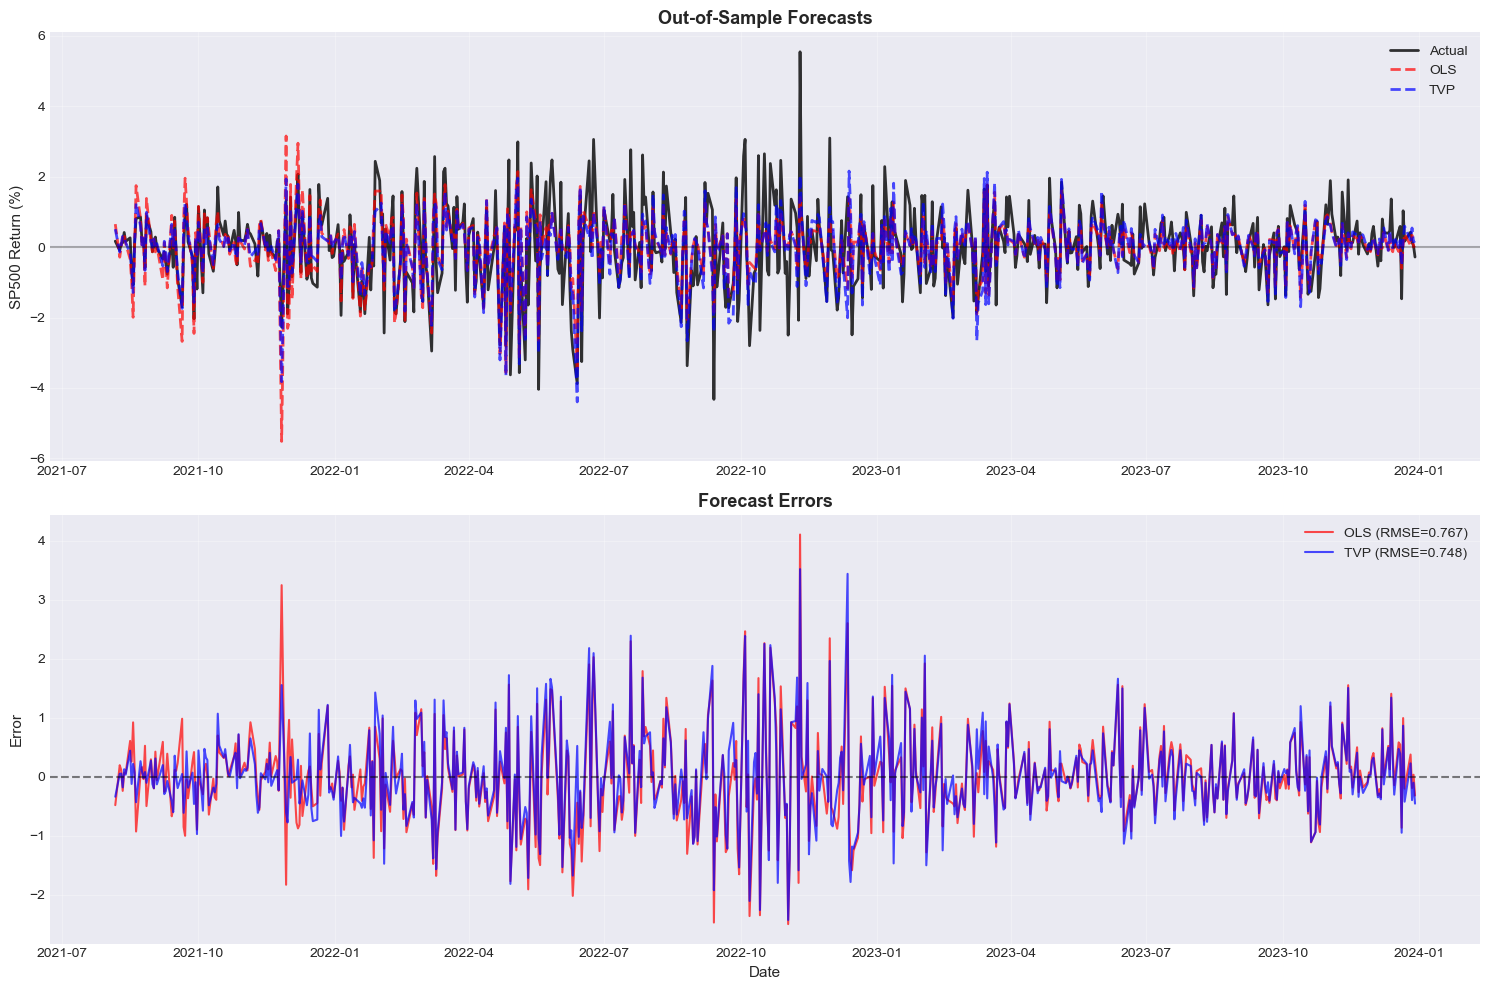


Forecasting Insights:
• TVP adapts to changing relationship
• OLS uses outdated average
• Improvement especially during volatile periods
• TVP provides better risk assessment


In [22]:
# Visualize forecasts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

test_dates = df.index[train_size:]

# Forecasts
axes[0].plot(test_dates, y_test, linewidth=2, color='black',
            label='Actual', alpha=0.8)
axes[0].plot(test_dates, forecast_ols, linewidth=2, color='red',
            label='OLS', linestyle='--', alpha=0.7)
axes[0].plot(test_dates, forecast_tvp, linewidth=2, color='blue',
            label='TVP', linestyle='--', alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].set_title('Out-of-Sample Forecasts', fontsize=13, fontweight='bold')
axes[0].set_ylabel('SP500 Return (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Forecast errors
axes[1].plot(test_dates, error_ols, linewidth=1.5, color='red',
            label=f'OLS (RMSE={rmse_ols:.3f})', alpha=0.7)
axes[1].plot(test_dates, error_tvp, linewidth=1.5, color='blue',
            label=f'TVP (RMSE={rmse_tvp:.3f})', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Forecast Errors', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nForecasting Insights:")
print("• TVP adapts to changing relationship")
print("• OLS uses outdated average")
print("• Improvement especially during volatile periods")
print("• TVP provides better risk assessment")

## 5. Summary and Preview of Session 11

### 5.1 Key Takeaways from Session 10

**Why TVP models?**
- Economic relationships change over time
- Structural breaks, regime changes
- Constant parameters often inadequate

**State space framework**:
- Observation equation: Links data to states
- State equation: Evolution of parameters
- Kalman filter: Optimal estimation

**TVP regression**:
- Parameters follow random walk
- Q controls speed of variation
- Bias-variance tradeoff

**Estimation methods**:
- OLS: Simple but misses variation
- Rolling: Adaptive but inefficient
- Kalman: Optimal but needs tuning

**Forecasting**:
- TVP often outperforms constant parameter
- Especially during regime changes
- Proper uncertainty quantification

### 5.2 Session 11 Preview: TVP-VAR Models

**Extension to multivariate**:
- All VAR coefficients time-varying
- Time-varying covariance matrix
- Stochastic volatility

**TVP-VAR specification**:
$$\mathbf{y}_t = \mathbf{X}_t \boldsymbol{\beta}_t + \mathbf{A}_t^{-1} \boldsymbol{\Sigma}_t \mathbf{\epsilon}_t$$
$$\boldsymbol{\beta}_t = \boldsymbol{\beta}_{t-1} + \boldsymbol{\nu}_t$$
$$a_{ij,t} = a_{ij,t-1} + \zeta_{ij,t}$$
$$\log \sigma_{i,t}^2 = \log \sigma_{i,t-1}^2 + \eta_{i,t}$$

**Applications**:
- Time-varying impulse responses
- Dynamic spillovers and connectedness
- Structural change in macro relationships
- Financial contagion analysis

**Estimation**:
- MCMC (Gibbs sampling)
- Bayesian approach with priors
- Computational challenges

**Software**:
- Python implementations
- MATLAB toolboxes
- R packages

## 6. Exercises

### Exercise 1: Rolling Window Analysis
For a bivariate regression of your choice:
1. Estimate with full sample OLS
2. Implement rolling window (try windows: 60, 120, 252 days)
3. Plot coefficient evolution
4. Which window size works best?
5. Compare stability across windows

### Exercise 2: Kalman Filter Implementation
Implement Kalman filter from scratch:
1. Choose a simple TVP regression
2. Code prediction and update steps
3. Verify against provided class
4. Try different initial conditions
5. Implement smoother

### Exercise 3: Hyperparameter Selection
For TVP model:
1. Create grid of Q values
2. Estimate model for each Q
3. Calculate log-likelihood
4. Select optimal Q (AIC/BIC)
5. Compare with subjective choice

### Exercise 4: Structural Break Detection
Test for structural breaks:
1. Estimate TVP model
2. Identify periods of rapid parameter change
3. Compare with known events (crises)
4. Perform Chow test at detected breaks
5. Economic interpretation

### Exercise 5: Forecast Comparison
Compare forecasting performance:
1. Use expanding window (add one obs at a time)
2. Generate 1-step forecasts: OLS, Rolling, TVP
3. Calculate RMSE, MAE for each method
4. Test statistical significance (Diebold-Mariano)
5. When does TVP help most?

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Seminal Papers:
1. Kalman, R.E. (1960). A new approach to linear filtering and prediction problems. *Journal of Basic Engineering*, 82(1), 35-45.
2. Harvey, A.C. (1989). *Forecasting, Structural Time Series Models and the Kalman Filter*. Cambridge University Press.
3. Cogley, T., & Sargent, T.J. (2005). Drifts and volatilities: Monetary policies and outcomes in the post WWII US. *Review of Economic Dynamics*, 8(2), 262-302.
4. Primiceri, G.E. (2005). Time varying structural vector autoregressions and monetary policy. *Review of Economic Studies*, 72(3), 821-852.

### Textbooks:
1. Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press. Chapter 13.
2. Durbin, J., & Koopman, S.J. (2012). *Time Series Analysis by State Space Methods* (2nd ed.). Oxford University Press.
3. Kim, C.J., & Nelson, C.R. (1999). *State-Space Models with Regime Switching*. MIT Press.

### Applied Papers:
1. Stock, J.H., & Watson, M.W. (1996). Evidence on structural instability in macroeconomic time series relations. *Journal of Business & Economic Statistics*, 14(1), 11-30.
2. Clark, T.E., & McCracken, M.W. (2009). Improving forecast accuracy by combining recursive and rolling forecasts. *International Economic Review*, 50(2), 363-395.

### Software:
1. Statsmodels State Space: https://www.statsmodels.org/stable/statespace.html
2. PyKalman: https://pykalman.github.io/
3. FilterPy: https://filterpy.readthedocs.io/

### Online Resources:
1. Kevin Sheppard's Notes: https://www.kevinsheppard.com/
2. Kalman Filter Tutorial: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]